In [15]:
import ast
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# 1. Load and expand prompts
# ----------------------------

# change this to your actual filename
INPUT_CSV = "journal_prompts_filtered.csv"

df = pd.read_csv(INPUT_CSV, low_memory=False)

# parse the 'data' column from string into Python list
df["data_list"] = df["data"].apply(ast.literal_eval)

# expand: one row per (uid, day, prompt)
rows = []
for _, r in df.iterrows():
    uid = r["uid"]
    day = r["day"]
    data_list = r["data_list"]

    # assuming structure like ["Text", prompt1, prompt2, prompt3]
    prompts = data_list[1:]  # skip the first "Text" token

    for p in prompts:
        rows.append({
            "uid": uid,
            "day": day,
            "prompt": p.strip()
        })

df_long = pd.DataFrame(rows)

print("Number of expanded prompt rows:", len(df_long))
print(df_long.head())

# ----------------------------
# 2. Define category prototypes
# ----------------------------

prototypes = {
    "social_interaction": [
        "Your recent social interactions have decreased. Reflect on who you could reconnect with.",
        "You've had fewer conversations lately; think about meaningful connections.",
        "Noticing a dip in social interactions, think of someone you've lost touch with and reconnect."
    ],
    "digital_habits": [
        "Your phone usage has decreased lately. Reflect on how this changes your daily routine.",
        "You've been on your phone less; consider how that affects your habits.",
        "Your mobile trends show less phone use; how has that impacted your day?"
    ],
    "physical_fitness": [
        "You've been walking more recently. Reflect on how physical activity affects your day.",
        "Your activity levels changed lately; think about your fitness and movement.",
        "Notice any changes in your exercise or daily steps and how they make you feel."
    ],
    "sleep": [
        "Your sleep hours have changed recently. Reflect on how rested you feel.",
        "Your recent sleep patterns show variation; think about your energy levels.",
        "Reflect on your bedtime and wake time and how they affect your day."
    ],
    "general": [
        "Hello! What's on your mind today? Use this journal entry to explore freely any thoughts, feelings, memories, or experiences -- anything you'd like.",
        "failure",
        "Who in your life deserves a 'thank you' this week, and what for?",
        "Reflect on a specific moment this week when you felt understood by someone. How did it affect your day? Thanks for sharing your journey!",
        "Reflect on a challenge from this week you turned into a learning opportunity. Keep on thriving!",
        "Reflect on a recent challenge you overcame this week. How did it contribute to your personal growth? Keep thriving!",
        "Reflect on a challenge from this week you turned into a learning opportunity. Keep on thriving!"
    ]
}

# ----------------------------
# 3. Load embedding model and encode prototypes
# ----------------------------

model = SentenceTransformer("all-MiniLM-L6-v2")

proto_emb = {
    cat: model.encode(examples, convert_to_tensor=True)
    for cat, examples in prototypes.items()
}

# ----------------------------
# 4. Categorization function
# ----------------------------

def categorize_prompt(prompt: str) -> str:
    emb = model.encode(prompt, convert_to_tensor=True)

    best_cat = None
    best_score = -1.0

    for cat, proto_vecs in proto_emb.items():
        # cosine similarity to all prototypes in this category, take max
        sim = util.cos_sim(emb, proto_vecs).max().item()
        if sim > best_score:
            best_score = sim
            best_cat = cat

    return best_cat

# apply to all prompts
df_long["category"] = df_long["prompt"].apply(categorize_prompt)

print("\nCategory counts overall:")
print(df_long["category"].value_counts())

print("\nExample labeled prompts:")
print(df_long[["prompt", "category"]].head(10))

# ----------------------------
# 5. Count prompts per UID per category
# ----------------------------

counts = (
    df_long
    .groupby(["uid", "category"])
    .size()
    .reset_index(name="count")
)

counts_pivot = (
    counts
    .pivot(index="uid", columns="category", values="count")
    .fillna(0)
    .reset_index()
)

print("\nUID x category table (first few rows):")
print(counts_pivot.head())

# ----------------------------
# 6. Save outputs
# ----------------------------

df_long.to_csv("journal_prompts_with_category.csv", index=False)
counts_pivot.to_csv("uid_prompt_category_counts.csv", index=False)

print("\nSaved:")
print("  - journal_prompts_with_category.csv")
print("  - uid_prompt_category_counts.csv")
print("newv1")

Number of expanded prompt rows: 1998
              uid                      day  \
0  t0002@sreflect  2024-02-01 21:34:57.970   
1  t0002@sreflect  2024-02-01 21:34:57.970   
2  t0002@sreflect  2024-02-01 21:34:57.970   
3  t0003@sreflect  2024-02-01 21:32:33.181   
4  t0003@sreflect  2024-02-01 21:32:33.181   

                                              prompt  
0  Your mobile trends show less phone use and dec...  
1  You seem to have had less in-person interactio...  
2  Your mobile trends show less phone use and dec...  
3  Your social interactions have lessened recentl...  
4  Noticing a little less chit-chat lately? Share...  

Category counts overall:
category
general               794
digital_habits        419
social_interaction    377
physical_fitness      268
sleep                 140
Name: count, dtype: int64

Example labeled prompts:
                                              prompt            category
0  Your mobile trends show less phone use and dec...      digital_

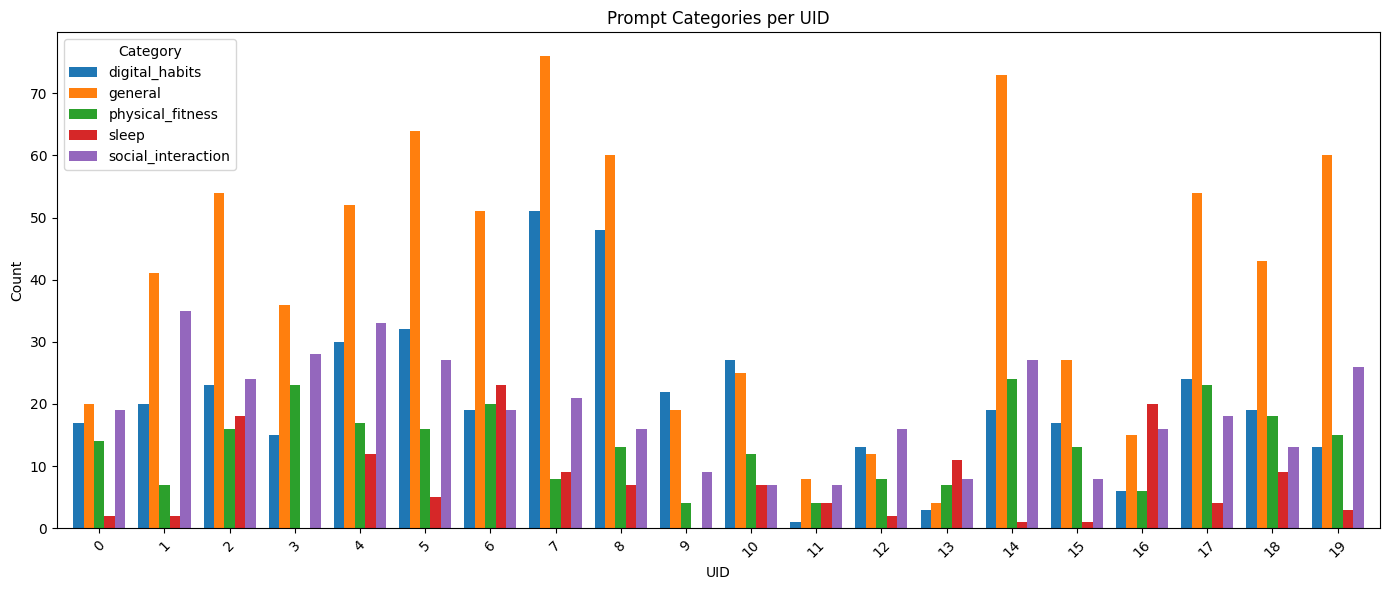

In [19]:

import matplotlib.pyplot as plt
counts_pivot.plot(
    kind="bar",
    figsize=(14, 6),
    width=0.8
)

plt.title("Prompt Categories per UID")
plt.xlabel("UID")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.tight_layout()
plt.show()


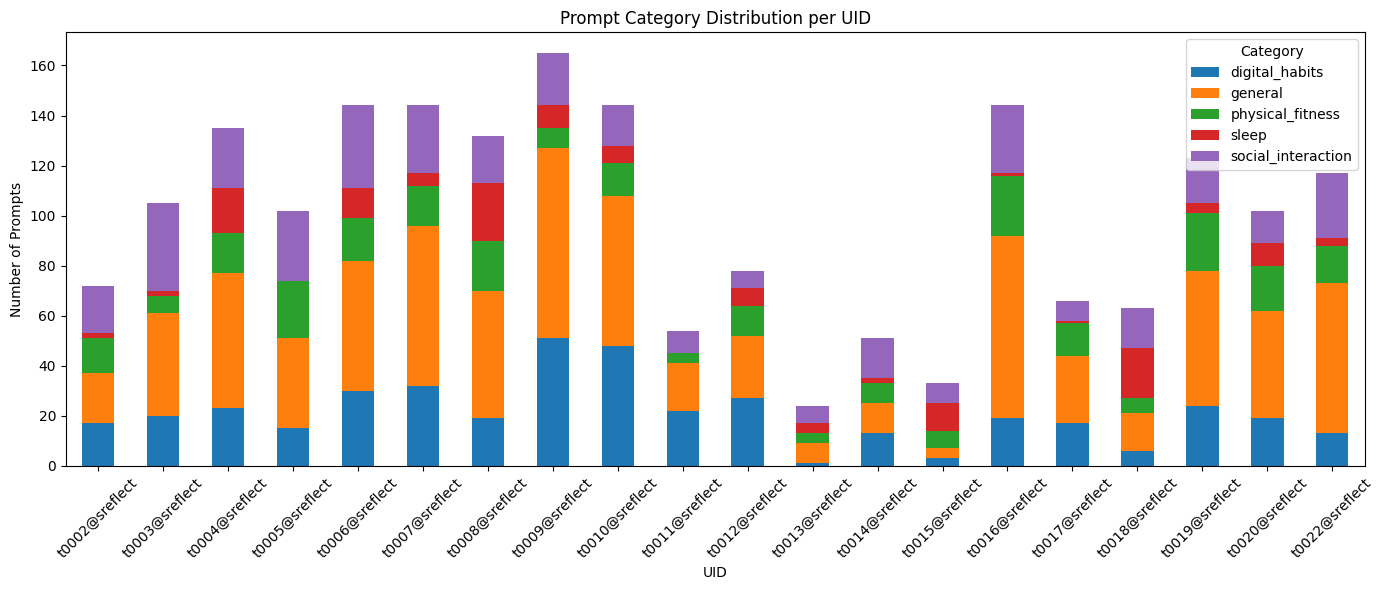

In [20]:
import matplotlib.pyplot as plt

# Ensure uid is string
counts_pivot['uid'] = counts_pivot['uid'].astype(str)

# Set uid as x-axis
counts_pivot_plot = counts_pivot.set_index("uid")

counts_pivot_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6)
)

plt.title("Prompt Category Distribution per UID")
plt.xlabel("UID")
plt.ylabel("Number of Prompts")
plt.legend(title="Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
